In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

In [3]:
from b2bH_vlq import get_variable_group_names, get_variables_by_group
get_variable_group_names()

['vlq',
 'photon-1',
 'photon-2',
 'diphoton',
 'b-jet-1',
 'b-jet-2',
 'fwd-jet',
 'event',
 'deltaR',
 'masses']

In [4]:
all_vars = {}
for gr in get_variable_group_names():
    all_vars.update(get_variables_by_group(gr))
all_vars.keys()

dict_keys(['VLQ_pt', 'VLQ_eta', 'VLQ_phi', 'photon1_pt', 'photon1_phi', 'photon1_y', 'photon1_eta', 'photon2_pt', 'photon2_phi', 'photon2_y', 'photon2_eta', 'diphoton_pt', 'diphoton_phi', 'diphoton_y', 'diphoton_eta', 'bjet_pt', 'bjet_phi', 'bjet_y', 'bjet_eta', 'bjet2_pt', 'bjet2_phi', 'bjet2_y', 'bjet2_eta', 'forward_jet_pt', 'forward_jet_phi', 'forward_jet_y', 'forward_jet_eta', 'HT', 'bjet_multiplicity', 'jet_multiplicity', 'forwardjet_multiplicity', 'deltaR_bjet_Higgs', 'VLQ_mass', 'diphoton_mass'])

In [5]:
from hepkit.histograms import hist1d_from_var, plot_hist1d_comparison, multi_hist1d_comparison
from hepkit.plotting import set_cms_style, create_multiplot_layout
set_cms_style(grid=True)

### Load signal and bkg files

In [6]:
t_sig = uproot.open("../data/BDT_tree_M800_14TeV.root:BbH_tree")
t_bkg = uproot.open("../data/BKG_tree_tHq_14TeV.root:BbH_tree")

In [7]:
df_sig = t_sig.arrays(library="pd")
df_bkg = t_bkg.arrays(library="pd")

In [19]:
w_sig = df_sig["evt_weight"]
w_bkg = df_bkg["evt_weight"]

- Convert multiplicity columns to integers originally stored as float
- Create unique ids based on the Event number (Nevts column)

In [8]:
# Convert multiplicity columns to integers
df_sig = df_sig.astype({
    'n_bjet': 'int32',
    'n_jets': 'int32',
    'n_fjet': 'int32',
},)
df_bkg = df_bkg.astype({
    'n_bjet': 'int32',
    'n_jets': 'int32',
    'n_fjet': 'int32',
},)

## BDT training

We'll use catboost classifier por signal background classification.

Select as input features kinematic variables $p_{T}$ and $\eta$ from  the VLQ candidate and its decay products.
Also include $H_{T}$ and deltaR between b-jet and Higgs candidates.

In [12]:
cands = ["photon1", "photon2", "diphoton", "bjet", "VLQ"]
obs = ["pt", "eta"]

mva_vars = { }
for cand, obs in product(cands, obs):
    key = f"{cand}_{obs}"
    mva_vars[key] = all_vars[key]
mva_vars["HT"] = all_vars["HT"]
mva_vars["deltaR_bjet_Higgs"] = all_vars["deltaR_bjet_Higgs"]
mva_vars.keys()

dict_keys(['photon1_pt', 'photon1_eta', 'photon2_pt', 'photon2_eta', 'diphoton_pt', 'diphoton_eta', 'bjet_pt', 'bjet_eta', 'VLQ_pt', 'VLQ_eta', 'HT', 'deltaR_bjet_Higgs'])

In [14]:
mva_names = list(mva_vars.keys())
sig_mva_hist = {}
bkg_mva_hist = {}
for name in mva_names:
    var = mva_vars[name]
    sig_mva_hist[name] = hist1d_from_var(var, df_sig)
    bkg_mva_hist[name] = hist1d_from_var(var, df_bkg)

In [15]:
from sklearn.model_selection import train_test_split
from hepkit.classification.preprocessing import prepare_training_data, split_train_test_by_unique_id

In [16]:
from hepkit.classification.visualization import (
    plot_signal_background_comparison,
    plot_train_test_response,
    plot_signal_efficiency_vs_background_rejection,
    plot_roc_auc,
    # plot_shap_summary
)

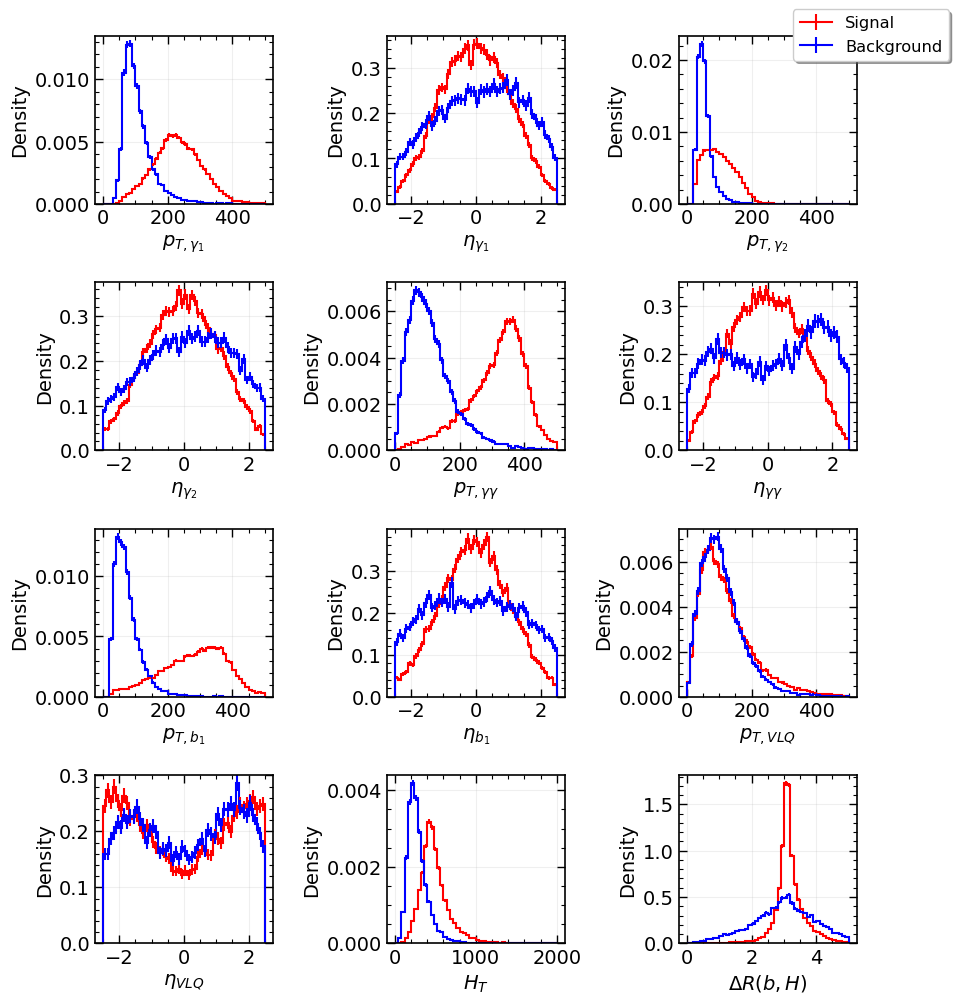

In [17]:
fig, axes = plot_signal_background_comparison(
    sig_mva_hist, bkg_mva_hist, subplot_titles=False
)
plt.tight_layout()

In [31]:
Xy, ids = prepare_training_data(
    df_sig,
    df_bkg,
    mva_vars.values(),
    mva_vars.values(),
    sig_weights=w_sig,
    bkg_weights=w_bkg,
    id_columns=["NEvts"]
)

In [32]:
train_set, test_set = split_train_test_by_unique_id(
    Xy, ids, test_ratio=0.2, id_columns=["NEvts"], 
)

In [33]:
# Define the training and validation sets
train_X, val_X, train_y, val_y = train_test_split(
    train_set.drop("label", axis=1), train_set["label"], test_size=0.2, random_state=42
)

In [34]:
train_weights = train_X.pop("weights")
val_weights = val_X.pop("weights")

Train the model

In [35]:
import catboost
from catboost import CatBoostClassifier, EFeaturesSelectionAlgorithm, EShapCalcType, Pool

In [63]:
train_pool = Pool(data=train_X, label=train_y, weight=train_weights)
val_pool = Pool(data=val_X, label=val_y, weight=val_weights)

In [70]:
train_pool = Pool(data=train_X, label=train_y)
val_pool = Pool(data=val_X, label=val_y)

In [71]:
cb_params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "custom_metric": ["Accuracy", "Precision"],  # "Recall", "F1"],
    "iterations": 2500,
    "random_state": 42,
    "learning_rate": 0.05,
    "depth": 2,
    #'rsm': 0.5,
    #'reg_lambda': 1,
    'od_wait': 100,
}

In [72]:
cv_data = catboost.cv(
    params=cb_params,
    pool=train_pool,
    fold_count=5,
    partition_random_seed=42,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9785757793
bestIteration = 834

Training on fold [1/5]

bestTest = 0.9774347741
bestIteration = 1042

Training on fold [2/5]

bestTest = 0.9787049164
bestIteration = 1040

Training on fold [3/5]

bestTest = 0.9803342789
bestIteration = 1478

Training on fold [4/5]

bestTest = 0.9762496557
bestIteration = 1030



In [73]:
best_value = cv_data["test-Logloss-mean"].min()
best_iter = cv_data["test-Logloss-mean"].values.argmin()
print(best_iter, best_value)

1477 0.1780409591378922


In [74]:
model = CatBoostClassifier(**cb_params)
model.fit(train_pool, eval_set=val_pool, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [75]:
train_predict = model.predict(train_X)
train_proba = model.predict_proba(train_X) # these are the scores
val_predict = model.predict(val_X)
val_proba = model.predict_proba(val_X) # these are the scores

Check overfitting

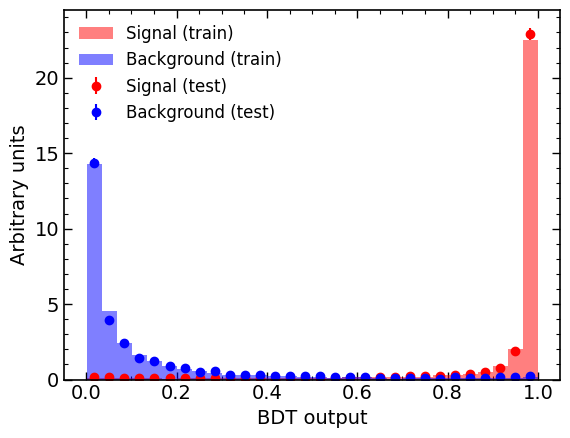

In [127]:
plot_train_test_response(
    model,
    train_X, train_y, val_X, val_y, log_y=False
)

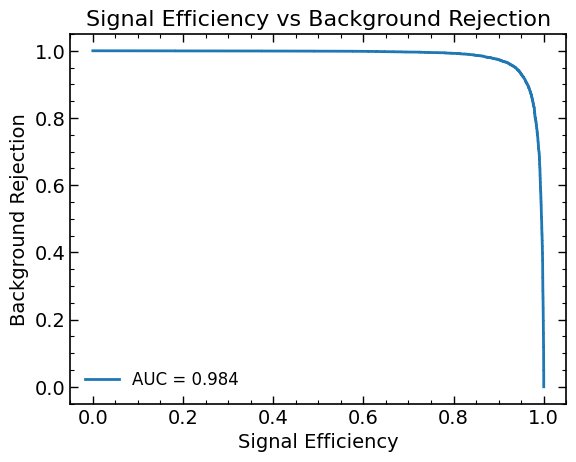

In [128]:
plot_signal_efficiency_vs_background_rejection(train_y, train_proba[:, 1])

## xGboost

In [129]:
import xgboost as xgb

In [130]:
model_xgb = xgb.XGBClassifier(
    n_estimators=2500,
    max_depth=2,
    learning_rate=0.05,
    random_state=42,
    early_stopping_rounds=100,
)

In [132]:
model_xgb.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,None


In [133]:
train_predict_xgb = model_xgb.predict(train_X)
train_proba_xgb = model_xgb.predict_proba(train_X) # these are the scores
val_predict_xgb = model_xgb.predict(val_X)
val_proba_xgb = model_xgb.predict_proba(val_X) # these are the scores

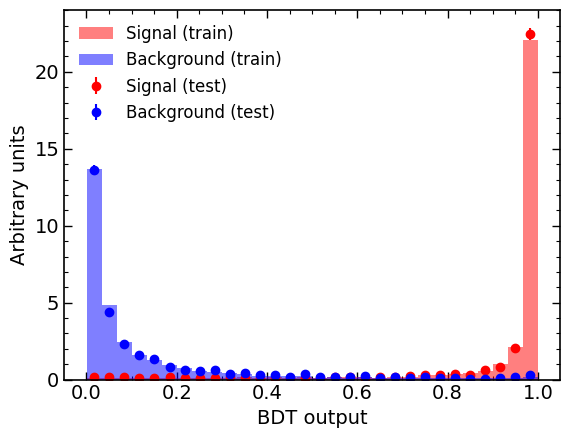

In [134]:
plot_train_test_response(
    model_xgb,
    train_X, train_y, val_X, val_y, log_y=False
)

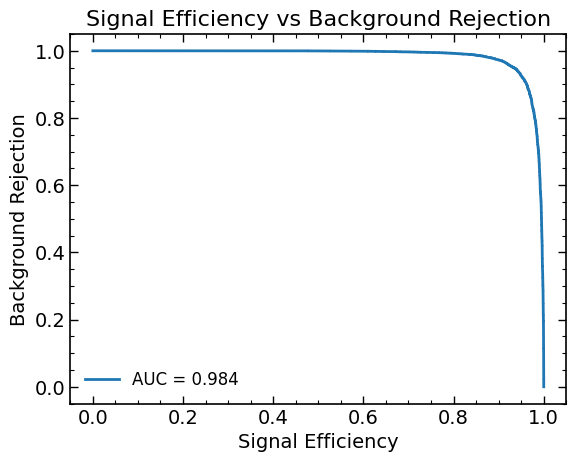

In [136]:
plot_signal_efficiency_vs_background_rejection(train_y, train_proba_xgb[:, 1])